# Import libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# Load Data 

In [13]:
eda_df = pd.read_csv('./src/notebooks/data/wesad_eda_empatica.csv', sep=';')
bvp_df = pd.read_csv('./src/notebooks/data/wesad_bvp_empatica.csv', sep=';')
acc_df = pd.read_csv('./src/notebooks/data/wesad_acc_empatica.csv', sep=';')
temp_df = pd.read_csv('./src/notebooks/data/wesad_temp_empatica.csv', sep=';')
resp_df = pd.read_csv('./src/notebooks/data/wesad_resp_empatica.csv', sep=';')
emg_df = pd.read_csv('./src/notebooks/data/wesad_emg_empatica.csv', sep=';')
ecg_df = pd.read_csv('./src/notebooks/data/wesad_ecg_empatica.csv', sep=';')
label_df = pd.read_csv('./src/notebooks/data/wesad_label_empatica.csv', sep=';')

# Feature extraction

In [93]:
def non_overlapping_rolling_stats(data, window_size, signal_name):
    mean_vals = []
    std_vals = []
    min_vals = []
    max_vals = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mean_vals.append(window_data.mean())
            std_vals.append(window_data.std())
            min_vals.append(window_data.min())
            max_vals.append(window_data.max())
    
    result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals
    })
    return result

In [164]:
def feature_extraction(data, window_size, signal_name) : 
    subjects_lst = data.subject.unique() 

    temp_subject_lst = []
    temp_feats_lst = []
    for subject in subjects_lst : 
        subject_data = data[data['subject'] == subject][signal_name] 
        features = non_overlapping_rolling_stats(data=subject_data, window_size=window_size, signal_name=signal_name)
        temp_feats_lst.append(features)
        for _ in range(0, int(features.shape[0])) : 
            temp_subject_lst.append(subject)


    features = pd.DataFrame()
    for feat_df in temp_feats_lst : 
        features = pd.concat([features, feat_df], axis=0)



    features = features.reset_index()
    features = pd.concat([features, pd.DataFrame(temp_subject_lst)], axis=1)
    features = features.rename(columns={
        0 : 'subject'
    })
    
    print(f'{signal_name} feature extraction : feature set shape : {features.shape}')
    
    return features


In [148]:
import pandas as pd
import numpy as np
from scipy.stats import mode

window_size = 4

def non_overlapping_rolling_labels(data, window_size):
    mode_vals = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mode_vals.append(mode(window_data).mode)  
    
    result = pd.DataFrame({
        'label': mode_vals
    })
    return result

In [180]:
window_size = 4
eda_features = feature_extraction(eda_df, window_size=window_size, signal_name=eda_df.columns[1])
temp_features = feature_extraction(temp_df, window_size=window_size, signal_name=temp_df.columns[1])
window_size = 32
x_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='x_axis')
y_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='y_axis')
z_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='z_axis')

window_size = 64
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name=bvp_df.columns[1])

window_size = 700 
resp_features = feature_extraction(resp_df, window_size=window_size, signal_name=resp_df.columns[1])
ecg_features = feature_extraction(ecg_df, window_size=window_size, signal_name=ecg_df.columns[1])
emg_features = feature_extraction(emg_df, window_size=window_size, signal_name=emg_df.columns[1])


EDA feature extraction : feature set shape : (82440, 6)
TEMP feature extraction : feature set shape : (82440, 6)
x_axis feature extraction : feature set shape : (82440, 6)
y_axis feature extraction : feature set shape : (82440, 6)
z_axis feature extraction : feature set shape : (82440, 6)
BVP feature extraction : feature set shape : (82440, 6)
RESP feature extraction : feature set shape : (82440, 6)
ECG feature extraction : feature set shape : (82440, 6)
EMG feature extraction : feature set shape : (82440, 6)


In [165]:
window_size = 64
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name=bvp_df.columns[1])

BVP feature extraction : feature set shape : (82440, 6)


In [149]:
window_size = 700 
labels = non_overlapping_rolling_labels(label_df['label'], window_size=window_size)

In [142]:
# chech that the feature extraction is done correctly. 

print(f'----------------------------------------------')
print(f'labels shape : {labels.shape}')
print(f'eda_features shape : {eda_features.shape}')
print(f'temp_features shape : {temp_features.shape}')
print(f'x_acc_features shape : {x_acc_features.shape}')
print(f'y_acc_features shape : {y_acc_features.shape}')
print(f'z_acc_features shape : {z_acc_features.shape}')
print(f'resp_features shape : {resp_features.shape}')
print(f'emg_features shape : {emg_features.shape}')
print(f'ecg_features shape : {ecg_features.shape}')
print(f'labels shape : {labels.shape}')
print(f'----------------------------------------------')

----------------------------------------------
labels shape : (82440, 1)
eda_features shape : (82440, 6)
temp_features shape : (82440, 6)
x_acc_features shape : (82440, 6)
y_acc_features shape : (82440, 6)
z_acc_features shape : (82440, 6)
resp_features shape : (82440, 6)
emg_features shape : (82440, 6)
ecg_features shape : (82440, 6)
labels shape : (82440, 1)
----------------------------------------------


# Data Transformation 

In [188]:
feature_set = pd.DataFrame()
feature_set = pd.concat([feature_set, eda_features, temp_features, 
                         x_acc_features, y_acc_features, z_acc_features, 
                         bvp_features, resp_features, emg_features, ecg_features, 
                         labels], 
                        axis=1) 

feature_set

,index,EDAmean,EDAstd,EDAmin,EDAmax,subject,index,TEMPmean,TEMPstd,TEMPmin,...,EMGmin,EMGmax,subject,index,ECGmean,ECGstd,ECGmin,ECGmax,subject,label
0,0,0.345697,0.006385,0.336423,0.350494,S10,0,33.1525,0.015,33.13,...,-0.063171,0.063400,S10,0,0.008149,0.708853,-1.333694,1.473129,S10,0
1,1,0.336743,0.003960,0.331306,0.340260,S10,1,33.1525,0.005,33.15,...,-0.040329,0.029526,S10,1,0.115067,0.215866,-0.431808,0.805618,S10,0
2,2,0.336103,0.001609,0.333865,0.337702,S10,2,33.1575,0.005,33.15,...,-0.036438,0.029709,S10,2,-0.030732,0.167507,-0.475388,0.716354,S10,0
3,3,0.336103,0.000640,0.335144,0.336423,S10,3,33.1525,0.005,33.15,...,-0.049622,0.032730,S10,3,0.008302,0.153476,-0.470581,0.888290,S10,0
4,4,0.335144,0.000000,0.335144,0.335144,S10,4,33.1575,0.005,33.15,...,-0.042847,0.020828,S10,4,-0.029259,0.180918,-0.449020,0.880417,S10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82435,5491,0.956198,0.002185,0.953320,0.958437,S9,5491,30.8450,0.010,30.83,...,-0.051086,0.031631,S9,5491,0.020745,0.143736,-0.400681,0.726608,S9,0
82436,5492,0.953640,0.001225,0.952041,0.954600,S9,5492,30.8500,0.000,30.85,...,-0.045273,0.025955,S9,5492,-0.001353,0.148725,-0.486282,0.676437,S9,0
82437,5493,0.952681,0.001279,0.952041,0.954600,S9,5493,30.8350,0.010,30.83,...,-0.048477,0.024216,S9,5493,0.001035,0.166538,-0.457443,0.731369,S9,0
82438,5494,0.946285,0.003977,0.941808,0.950762,S9,5494,30.8450,0.010,30.83,...,-0.052505,0.025589,S9,5494,-0.006044,0.148401,-0.439499,0.783463,S9,0


In [189]:
# Remove label and subject columns to perform data transformations

feature_set_ = feature_set.drop(labels=['index'], axis=1)
feature_set_ = feature_set_.T.drop_duplicates().T # Remove duplicate subject columns
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EDAmean     82440 non-null  object
 1   EDAstd      82440 non-null  object
 2   EDAmin      82440 non-null  object
 3   EDAmax      82440 non-null  object
 4   subject     82440 non-null  object
 5   TEMPmean    82440 non-null  object
 6   TEMPstd     82440 non-null  object
 7   TEMPmin     82440 non-null  object
 8   TEMPmax     82440 non-null  object
 9   x_axismean  82440 non-null  object
 10  x_axisstd   82440 non-null  object
 11  x_axismin   82440 non-null  object
 12  x_axismax   82440 non-null  object
 13  y_axismean  82440 non-null  object
 14  y_axisstd   82440 non-null  object
 15  y_axismin   82440 non-null  object
 16  y_axismax   82440 non-null  object
 17  z_axismean  82440 non-null  object
 18  z_axisstd   82440 non-null  object
 19  z_axismin   82440 non-null  object
 20  z_axis

In [190]:
# Remove subjects and labels columns 
labels_col = feature_set_.label 
feature_set_.drop(labels=['label'], axis=1, inplace=True)

subjects_col = feature_set_.subject      
feature_set_.drop(labels=['subject'], axis=1, inplace=True)

feature_set_.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EDAmean     82440 non-null  object
 1   EDAstd      82440 non-null  object
 2   EDAmin      82440 non-null  object
 3   EDAmax      82440 non-null  object
 4   TEMPmean    82440 non-null  object
 5   TEMPstd     82440 non-null  object
 6   TEMPmin     82440 non-null  object
 7   TEMPmax     82440 non-null  object
 8   x_axismean  82440 non-null  object
 9   x_axisstd   82440 non-null  object
 10  x_axismin   82440 non-null  object
 11  x_axismax   82440 non-null  object
 12  y_axismean  82440 non-null  object
 13  y_axisstd   82440 non-null  object
 14  y_axismin   82440 non-null  object
 15  y_axismax   82440 non-null  object
 16  z_axismean  82440 non-null  object
 17  z_axisstd   82440 non-null  object
 18  z_axismin   82440 non-null  object
 19  z_axismax   82440 non-null  object
 20  BVPmea

In [192]:
# Convert columns datatype to int 

feature_set_ = feature_set_.astype('float')
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EDAmean     82440 non-null  float64
 1   EDAstd      82440 non-null  float64
 2   EDAmin      82440 non-null  float64
 3   EDAmax      82440 non-null  float64
 4   TEMPmean    82440 non-null  float64
 5   TEMPstd     82440 non-null  float64
 6   TEMPmin     82440 non-null  float64
 7   TEMPmax     82440 non-null  float64
 8   x_axismean  82440 non-null  float64
 9   x_axisstd   82440 non-null  float64
 10  x_axismin   82440 non-null  float64
 11  x_axismax   82440 non-null  float64
 12  y_axismean  82440 non-null  float64
 13  y_axisstd   82440 non-null  float64
 14  y_axismin   82440 non-null  float64
 15  y_axismax   82440 non-null  float64
 16  z_axismean  82440 non-null  float64
 17  z_axisstd   82440 non-null  float64
 18  z_axismin   82440 non-null  float64
 19  z_axismax   82440 non-nul

In [247]:
# Data transformations : Quantile Transformer and Standard Scalar

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=20, svd_solver='full')
pca_df = pca.fit_transform(feature_set_)
pca_df = pd.DataFrame(pca_df, columns=[f'PC{i}' for i in range(1, 21)])
 

transformer = QuantileTransformer()
transformed_data = transformer.fit_transform(pca_df)
transformed_data = pd.DataFrame(transformed_data)
transformed_data.columns = pca_df.columns

scaler = StandardScaler()
scaled_data = scaler.fit_transform(transformed_data)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = transformed_data.columns


In [245]:
type(scaled_data.label.dtype.name)

str

In [249]:
# Put the subject and label column to the scaled data frame 
# to train the model using leave-one-subject-out cross validation

scaled_data['subject'] = subjects_col
scaled_data['label'] = labels_col

if scaled_data.label.dtype.name == "object" : 
    scaled_data.label = scaled_data.label.astype('int')

scaled_data.info()

change type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      82440 non-null  float64
 1   PC2      82440 non-null  float64
 2   PC3      82440 non-null  float64
 3   PC4      82440 non-null  float64
 4   PC5      82440 non-null  float64
 5   PC6      82440 non-null  float64
 6   PC7      82440 non-null  float64
 7   PC8      82440 non-null  float64
 8   PC9      82440 non-null  float64
 9   PC10     82440 non-null  float64
 10  PC11     82440 non-null  float64
 11  PC12     82440 non-null  float64
 12  PC13     82440 non-null  float64
 13  PC14     82440 non-null  float64
 14  PC15     82440 non-null  float64
 15  PC16     82440 non-null  float64
 16  PC17     82440 non-null  float64
 17  PC18     82440 non-null  float64
 18  PC19     82440 non-null  float64
 19  PC20     82440 non-null  float64
 20  subject  82440 non-null  object 
 21  

In [201]:
# Remove data points that does not belong to classes : [0, 1, 2] 
# Other data points have no interesting labels for out classification task
# for more details check weasd_readme.pdf 

# scaled_data_ is a scaled_data version used in training and testing.
scaled_data_ = scaled_data[(scaled_data['label'] == 0) | (scaled_data['label'] == 1) | (scaled_data['label'] == 2)]

In [204]:
# Calculate how many data points are lost 

print(f'- We have lost {scaled_data.shape[0] - scaled_data_.shape[0]} datasets')
print(f'- We have lost {((scaled_data.shape[0] - scaled_data_.shape[0]) / scaled_data.shape[0]) * 100} % of data')

- We have lost 19815 datasets
- We have lost 24.03566229985444 % of data


# Train the model 

## SVM 

<Axes: >

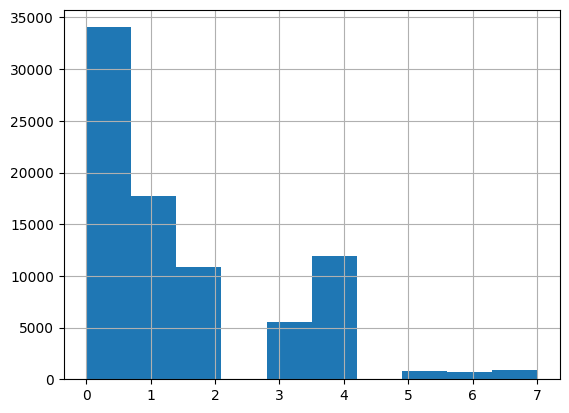

In [217]:
# Visualize the label distribution before filtering unwanted labels


scaled_data.label.hist()

<Axes: >

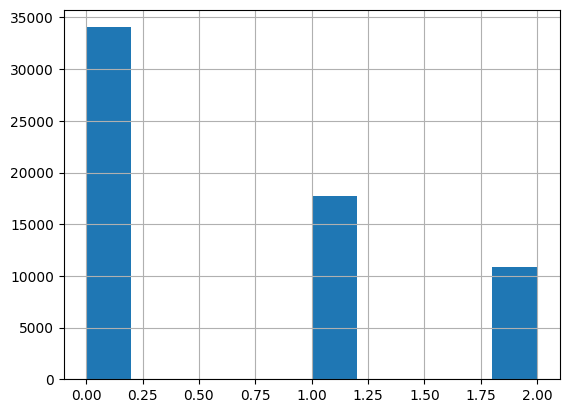

In [219]:
# Visualize the label distribution after filtering unwanted labels

scaled_data_.label.hist() 

In [222]:
scaled_data_.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'subject', 'label'],
      dtype='object')

In [228]:
# Due the label filtering, we need to update our list of subjects

subjects_col_ = scaled_data_.subject 
subjects_col_.shape

(62625,)

In [232]:
subjects_col_.values

array(['S10', 'S10', 'S10', ..., 'S9', 'S9', 'S9'], dtype=object)

In [237]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# model = SVC(kernel='rbf', C=10, gamma=0.001)
svm_model = SVC(kernel='rbf')
# model = SVC(kernel='rbf',  class_weight='balanced')

logo = LeaveOneGroupOut()

groups = subjects_col_
X = scaled_data_.drop(columns=['label', 'subject'])
y = scaled_data_.label 

svm_confusion_matrices = []
accuracies = []
f1_scores = []
subjects_ids = [] 

counter = 1

print(f"- len subjects_id : {len(subjects_col_)}")
print(f"- len subjects_id : {subjects_col_.shape}")
print(f"- len X : {len(X)}")
print(f"- len y : {len(y)}")


print(f"- Start the training process")
for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups), start=1):
    
    train_subjects = np.unique(groups.iloc[train_index])
    test_subjects = np.unique(groups.iloc[test_index])
    
    print(f"Fold {fold_idx}:")
    print(f"Subjects in testing set: {test_subjects}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    svm_confusion_matrices.append(cm)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)
    
    print(f"{fold_idx}- Accuracy: {accuracy:.2f}")
    print(f"{fold_idx}- f1-score: {f1:.2f}")

# Summary of results
accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
print(f"The avg accuracy: {accuracies.mean()}")
print(f"The avg f1_scores: {f1_scores.mean()}")
print(f"The std accuracy: {accuracies.std()}")
print(f"The min accuracy: {accuracies.min()}")
print(f"The max accuracy: {accuracies.max()}")

- len subjects_id : 62625
- len subjects_id : (62625,)
- len X : 62625
- len y : 62625
- Start the training process
Fold 1:
Subjects in testing set: ['S10']


ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.